In [1]:
import requests
import hashlib
import time
import datetime
from google.colab import userdata
import pandas as pd
import sqlite3

In [2]:
public_key=userdata.get('public_key_marvel')
private_key=userdata.get('private_key_marvel')
timestamp = str(time.time())
md5_hash= timestamp + private_key + public_key
md5_hash = hashlib.md5(md5_hash.encode("utf-8")).hexdigest()

DB_NAME = 'marvel_characters_teste.db'

# Requisição manual para testes

In [3]:
# Modifique a URL para o endpoint de personagens
url = f"https://gateway.marvel.com/v1/public/series?ts={timestamp}&apikey={public_key}&hash={md5_hash}"
print(url)
# Código de tratamento dos dados
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print(f"Total de personagens: {data['data']['total']}")
    for char in data['data']['results']:
        print(char)

https://gateway.marvel.com/v1/public/series?ts=1747835520.439936&apikey=a3d98cba75573256bce670cd3f0181e1&hash=a1a50c7fec5733b8714ce2134456157f
Total de personagens: 15702
{'id': 6026, 'title': ' (2008)', 'description': None, 'resourceURI': 'https://gateway.marvel.com/v1/public/series/6026', 'urls': [{'type': 'detail', 'url': 'http://marvel.com/comics/series/6026/_2008?utm_campaign=apiRef&utm_source=a3d98cba75573256bce670cd3f0181e1'}], 'startYear': 2008, 'endYear': 2008, 'rating': 'Rated a', 'type': '', 'modified': '2024-07-23T09:28:06+0000', 'thumbnail': {'path': 'http://i.annihil.us/u/prod/marvel/i/mg/b/90/4bb656aacb611', 'extension': 'jpg'}, 'creators': {'available': 34, 'collectionURI': 'https://gateway.marvel.com/v1/public/series/6026/creators', 'items': [{'resourceURI': 'https://gateway.marvel.com/v1/public/creators/1950', 'name': 'Joe Andreani', 'role': 'colorist'}, {'resourceURI': 'https://gateway.marvel.com/v1/public/creators/13215', 'name': 'Rain Beredo', 'role': 'colorist'}, 

# Criação banco de dados

In [ ]:
# conn = sqlite3.connect('marvel_characters_teste.db')
# cursor = conn.cursor()

# # Executar consulta com parâmetro
# cursor.execute('''
#     DROP TABLE IF EXISTS comics;
# ''')

In [17]:
 # Função para criar o banco
def create_database():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Tabela Personagens
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        description TEXT,
        modified TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        series_available INTEGER,
        series_collectionURI TEXT
    )''')

    # Tabela Comics
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS comics (
        id INTEGER PRIMARY KEY,
        digital_id INTENGER,
        title TEXT NOT NULL,
        issue_number INTEGER,
        description TEXT,
        variant_description TEXT,
        modified TEXT,
        format TEXT,
        page_count INTEGER,
        series_URI TEXT,
        series_name TEXT,
        price REAL,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT
    )''')

    # Tabela Series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS series (
        id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        description TEXT,
        start_year INTEGER,
        end_year INTEGER,
        rating TEXT,
        modified TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT
    )''')

    # Tabela Events
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS events (
        id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        description TEXT,
        modified TEXT,
        start TEXT,
        end TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT,
        series_available INTEGER,
        series_collectionURI TEXT
    )''')

    # Tabela de relacionamento characters e events
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters_events (
        id_character INTEGER,
        id_event INTEGER,
        PRIMARY KEY(id_character, id_event),
        FOREIGN KEY(id_character) REFERENCES characters(id),
        FOREIGN KEY(id_event) REFERENCES events(id)
    )''')

    # Tabela de relacionamento characters e series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters_series (
        id_character INTEGER,
        id_serie INTEGER,
        PRIMARY KEY(id_character, id_serie),
        FOREIGN KEY(id_character) REFERENCES characters(id),
        FOREIGN KEY(id_serie) REFERENCES series(id)
    )''')

    # Tabela de relacionamento events e series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS events_series (
        id_event INTEGER,
        id_serie INTEGER,
        PRIMARY KEY(id_event, id_serie),
        FOREIGN KEY(id_event) REFERENCES events(id),
        FOREIGN KEY(id_serie) REFERENCES series(id)
    )''')

    conn.commit()
    conn.close()

In [18]:
create_database()

# Extração de dados

In [ ]:
MAX_RETRIES = 3  # Tentativas por requisição
DELAY = 1  # Atraso entre requisições em segundos

In [ ]:
 # Função para pegar todos os personagens
def get_all_characters():
     conn = sqlite3.connect(DB_NAME)
     cursor = conn.cursor()

     offset = 0
     total = None
     inserted = 0

     while True:
         for attempt in range(MAX_RETRIES):
             try:
                 # Autenticação
                 ts = str(time.time())
                 hash_input = ts + private_key + public_key
                 md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

                 params = {
                     'ts': ts,
                     'apikey': public_key,
                     'hash': md5_hash,
                     'limit': 100,
                     'offset': offset
                 }

                 response = requests.get(
                     'https://gateway.marvel.com/v1/public/characters',
                     params=params,
                     timeout=10
                 )
                 response.raise_for_status()

                 data = response.json()
                 total = data['data']['total'] if total is None else total
                 results = data['data']['results']

                 # Inserir no banco
                 for char in results:
                     cursor.execute('''
                         INSERT OR REPLACE INTO characters
                         VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                     ''', (
                         char['id'],
                         char['name'],
                         char.get('description', ''),
                         char['modified'],
                         char['comics']['available'],
                         char['comics']['collectionURI'],
                         char['events']['available'],
                         char['events']['collectionURI'],
                         char['stories']['available'],
                         char['stories']['collectionURI'],
                         char['series']['available'],
                         char['series']['collectionURI'],
                     ))

                 conn.commit()
                 inserted += len(results)
                 print(f"Progresso: {inserted}/{total} ({inserted/total:.1%})")

                 # Verificar se terminou
                 if offset + len(results) >= total:
                     print("\nTodos os personagens foram armazenados!")
                     return

                 offset += 100
                 time.sleep(DELAY)
                 break  # Sai do loop de tentativas

             except requests.exceptions.RequestException as e:
                 print(f"Erro na requisição (tentativa {attempt+1}): {str(e)}")
                 time.sleep(2 ** attempt)  # Backoff exponencial
                 continue
         else:
             print("Falha após múltiplas tentativas. Abortando...")
             break

     conn.close()

In [ ]:
def get_all_events():
     conn = sqlite3.connect(DB_NAME)
     cursor = conn.cursor()

     offset = 0
     total = None
     inserted = 0

     while True:
         for attempt in range(MAX_RETRIES):
             try:
                 # Autenticação
                 ts = str(time.time())
                 hash_input = ts + private_key + public_key
                 md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

                 params = {
                     'ts': ts,
                     'apikey': public_key,
                     'hash': md5_hash,
                     'limit': 10,
                     'offset': offset
                 }
                 response = requests.get(
                     'https://gateway.marvel.com/v1/public/events',
                     params=params,
                     timeout=10
                 )
                 response.raise_for_status()
                 data = response.json()
                 total = data['data']['total'] if total is None else total
                 results = data['data']['results']

                 # Inserir no banco
                 for char in results:
                     cursor.execute('''
                         INSERT OR REPLACE INTO events
                         VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                     ''', (
                         char['id'],
                         char['title'],
                         char.get('description', ''),
                         char['modified'],
                         char['start'],
                         char['end'],
                         char['comics']['available'],
                         char['comics']['collectionURI'],
                         char['characters']['available'],
                         char['characters']['collectionURI'],
                         char['stories']['available'],
                         char['stories']['collectionURI'],
                         char['creators']['available'],
                         char['creators']['collectionURI'],
                         char['series']['available'],
                         char['series']['collectionURI']
                     ))

                 conn.commit()
                 inserted += len(results)
                 print(f"Progresso: {inserted}/{total} ({inserted/total:.1%})")

                 # Verificar se terminou
                 if offset + len(results) >= total:
                     print("\nTodos os eventos foram armazenados!")
                     return

                 offset += 10
                 time.sleep(DELAY)
                 break  # Sai do loop de tentativas

             except requests.exceptions.RequestException as e:
                 print(f"Erro na requisição (tentativa {attempt+1}): {str(e)}")
                 time.sleep(2 ** attempt)  # Backoff exponencial
                 continue
         else:
             print("Falha após múltiplas tentativas. Abortando...")
             break

     conn.close()

In [ ]:
def get_all_comics():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    offset = 0
    total = None
    inserted = 0
    DELAY = 1  # Atraso entre requisições

    while True:
        for attempt in range(MAX_RETRIES):
            try:
                # Autenticação
                ts = str(time.time())
                hash_input = ts + private_key + public_key
                md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

                params = {
                    'ts': ts,
                    'apikey': public_key,
                    'hash': md5_hash,
                    'limit': 100,
                    'offset': offset,
                    'orderBy': 'modified'  # Melhora a paginação
                }

                response = requests.get(
                    'https://gateway.marvel.com/v1/public/comics',
                    params=params,
                    timeout=10
                )
                response.raise_for_status()

                data = response.json()
                total = data['data']['total'] if total is None else total
                results = data['data']['results']

                for char in results:
                    cursor.execute('''
                            INSERT OR REPLACE INTO comics
                            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', (
                            char['id'],
                            char['digitalId'],
                            char['title'],
                            char['issueNumber'],
                            char.get('description', ''),
                            char['variantDescription'],
                            char['modified'],
                            char['format'],
                            char['pageCount'],
                            char['series']['resourceURI'],
                            char['series']['name'],
                            char['prices'][-1]['price'],
                            char['stories']['available'],
                            char['stories']['collectionURI'],
                            char['events']['available'],
                            char['events']['collectionURI'],
                            char['characters']['available'],
                            char['characters']['collectionURI'],
                            char['creators']['available'],
                            char['creators']['collectionURI'],
                        ))

                conn.commit()
                inserted += len(results)
                print(f"Progresso: {inserted}/{total} ({inserted/total:.1%})")

                if offset + len(results) >= total:
                    print("\nTodos os quadrinhos foram armazenados!")
                    return

                offset += 100
                time.sleep(DELAY)
                break

            except requests.exceptions.RequestException as e:
                print(f"Erro na requisição (tentativa {attempt+1}): {str(e)}")
                time.sleep(2 ** attempt)
                continue
        else:
            print("Falha após múltiplas tentativas. Abortando...")
            break

    conn.close()

In [ ]:
def get_all_series():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    offset = 0
    total = None
    inserted = 0
    DELAY = 1  # Atraso entre requisições

    while True:
        for attempt in range(MAX_RETRIES):
            try:
                # Autenticação
                ts = str(time.time())
                hash_input = ts + private_key + public_key
                md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

                params = {
                    'ts': ts,
                    'apikey': public_key,
                    'hash': md5_hash,
                    'limit': 100,
                    'offset': offset,
                    'orderBy': 'modified'  # Melhora a paginação
                }

                response = requests.get(
                    'https://gateway.marvel.com/v1/public/series',
                    params=params,
                    timeout=10
                )
                response.raise_for_status()

                data = response.json()
                total = data['data']['total'] if total is None else total
                results = data['data']['results']

                for char in results:
                    cursor.execute('''
                            INSERT OR REPLACE INTO series
                            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', (
                              char['id'],
                              char['title'],
                              char.get('description', ''),
                              char['startYear'],
                              char['endYear'],
                              char['rating'],
                              char['modified'],
                              char['comics']['available'],
                              char['comics']['collectionURI'],
                              char['stories']['available'],
                              char['stories']['collectionURI'],
                              char['events']['available'],
                              char['events']['collectionURI'],
                              char['characters']['available'],
                              char['characters']['collectionURI'],
                              char['creators']['available'],
                              char['creators']['collectionURI']
                        ))

                conn.commit()
                inserted += len(results)
                print(f"Progresso: {inserted}/{total} ({inserted/total:.1%})")

                if offset + len(results) >= total:
                    print("\nTodos as series foram armazenadas!")
                    return

                offset += 100
                time.sleep(DELAY)
                break

            except requests.exceptions.RequestException as e:
                print(f"Erro na requisição (tentativa {attempt+1}): {str(e)}")
                time.sleep(2 ** attempt)
                continue
        else:
            print("Falha após múltiplas tentativas. Abortando...")
            break

    conn.close()

In [ ]:
# get_all_characters()
# get_all_events()
get_all_comics()
#get_all_series()

 # Verificar
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM comics")
print(f"\nTotal no banco: {cursor.fetchone()[0]} comics")
conn.close()

#Tabelas de Relacionamentos

In [ ]:
from requests.exceptions import ReadTimeout, RequestException

BASE_TIMEOUT = 10
MAX_RETRIES = 3  # ajuste conforme sua necessidade

def character_events():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Lista para armazenar IDs de personagens que deram erro
    error_characters = []

    # Contador de requisições
    request_count = 0

    print("[INÍCIO] Conectado ao banco de dados")

    cursor.execute(
        'SELECT id, events_collectionURI FROM characters WHERE events_available > 0'
    )
    resultados = cursor.fetchall()
    total_chars = len(resultados)
    print(f"[BANCO] Total de personagens encontrados: {total_chars}")

    for idx, (id_character, events_collection) in enumerate(resultados, start=1):
        print(f"\n[PERSONAGEM {idx}/{total_chars}] Processando ID: {id_character}")

        try:
            ts = str(time.time())
            hash_input = ts + private_key + public_key
            md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

            params = {
                'ts': ts,
                'apikey': public_key,
                'hash': md5_hash,
                'limit': 50,      # ajustar se precisar
                'offset': 0
            }

            all_results = []
            total_events = 0

            # Paginação
            while True:
                for attempt in range(MAX_RETRIES):
                    current_timeout = BASE_TIMEOUT * (attempt + 1)
                    print(f"  [TENTATIVA {attempt + 1}/{MAX_RETRIES}] timeout={current_timeout}s")

                    try:
                        request_count += 1
                        response = requests.get(
                            events_collection,
                            params=params,
                            timeout=current_timeout
                        )
                        print(f"  [RESPOSTA] Status Code: {response.status_code}")
                        response.raise_for_status()
                        data = response.json()

                        # No offset 0 definimos total de eventos
                        if params['offset'] == 0:
                            total_events = data['data']['total']
                            print(f"  [INFO] Total de eventos para este personagem: {total_events}")

                        page_results = data['data']['results']
                        all_results.extend(page_results)
                        break

                    except ReadTimeout:
                        print("    [ERRO] ReadTimeout, fazendo retry")
                        if attempt < MAX_RETRIES - 1:
                            time.sleep(2 ** attempt)
                        else:
                            raise

                    except RequestException as e:
                        print(f"    [ERRO] RequestException: {e}")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(1)

                # condição de parada da paginação
                if params['offset'] + params['limit'] >= total_events:
                    break

                params['offset'] += params['limit']
                time.sleep(0.5)

            # Inserção no banco
            if all_results:
                print(f"  [BANCO] Inserindo {len(all_results)} eventos para personagem {id_character}")
                dados = [(id_character, event['id']) for event in all_results]
                cursor.executemany(
                    'INSERT OR IGNORE INTO characters_events VALUES (?, ?)',
                    dados
                )
                conn.commit()
            else:
                print("  [INFO] Nenhum evento para inserir")

        except Exception as e:
            # Registra o personagem que deu erro
            print(f"  [ERRO FATAL] Personagem {id_character} falhou: {e}")
            error_characters.append(id_character)

        # A cada 10 personagens, mostra os que falharam até aqui
        if idx % 10 == 0:
            print(f"\n[ERROS ATÉ O PERSONAGEM {idx}]: {error_characters}\n")

    conn.close()
    print("[BANCO] Conexão fechada")

    # Lista final de erros
    if error_characters:
        print(f"[RESUMO DE ERROS] Total de personagens com erro: {len(error_characters)}")
        print(error_characters)
    else:
        print("[RESUMO DE ERROS] Nenhum erro encontrado.")


In [9]:
BASE_TIMEOUT = 10
MAX_RETRIES = 3  # ajuste conforme sua necessidade

def character_series():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Lista para armazenar IDs de personagens que deram erro
    error_characters = []

    # Contador de requisições
    request_count = 0

    print("[INÍCIO] Conectado ao banco de dados")

    cursor.execute(
        'SELECT id, series_collectionURI FROM characters WHERE series_available > 0'
    )
    resultados = cursor.fetchall()
    total_chars = len(resultados)
    print(f"[BANCO] Total de personagens encontrados: {total_chars}")

    for idx, (id_character, series_collection) in enumerate(resultados, start=1):
        print(f"\n[PERSONAGEM {idx}/{total_chars}] Processando ID: {id_character}")

        try:
            ts = str(time.time())
            hash_input = ts + private_key + public_key
            md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

            params = {
                'ts': ts,
                'apikey': public_key,
                'hash': md5_hash,
                'limit': 100,      # ajustar se precisar
                'offset': 0
            }

            all_results = []
            total_series = 0

            # Paginação
            while True:
                for attempt in range(MAX_RETRIES):
                    current_timeout = BASE_TIMEOUT * (attempt + 1)
                    print(f"  [TENTATIVA {attempt + 1}/{MAX_RETRIES}] timeout={current_timeout}s")

                    try:
                        request_count += 1
                        response = requests.get(
                            series_collection,
                            params=params,
                            timeout=current_timeout
                        )
                        print(f"  [RESPOSTA] Status Code: {response.status_code}")
                        response.raise_for_status()
                        data = response.json()

                        # No offset 0 definimos total de series
                        if params['offset'] == 0:
                            total_series = data['data']['total']
                            print(f"  [INFO] Total de series para este personagem: {total_series}")

                        page_results = data['data']['results']
                        all_results.extend(page_results)
                        break

                    except ReadTimeout:
                        print("    [ERRO] ReadTimeout, fazendo retry")
                        if attempt < MAX_RETRIES - 1:
                            time.sleep(2 ** attempt)
                        else:
                            raise

                    except RequestException as e:
                        print(f"    [ERRO] RequestException: {e}")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(1)

                # condição de parada da paginação
                if params['offset'] + params['limit'] >= total_series:
                    break

                params['offset'] += params['limit']
                time.sleep(0.5)

            # Inserção no banco
            if all_results:
                print(f"  [BANCO] Inserindo {len(all_results)} eventos para personagem {id_character}")
                dados = [(id_character, event['id']) for event in all_results]
                cursor.executemany(
                    'INSERT OR IGNORE INTO characters_series VALUES (?, ?)',
                    dados
                )
                conn.commit()
            else:
                print("  [INFO] Nenhum evento para inserir")

        except Exception as e:
            # Registra o personagem que deu erro
            print(f"  [ERRO FATAL] Personagem {id_character} falhou: {e}")
            error_characters.append(id_character)

        # A cada 10 personagens, mostra os que falharam até aqui
        if idx % 10 == 0:
            print(f"\n[ERROS ATÉ O PERSONAGEM {idx}]: {error_characters}\n")

    conn.close()
    print("[BANCO] Conexão fechada")

    # Lista final de erros
    if error_characters:
        print(f"[RESUMO DE ERROS] Total de personagens com erro: {len(error_characters)}")
        print(error_characters)
    else:
        print("[RESUMO DE ERROS] Nenhum erro encontrado.")


In [19]:
BASE_TIMEOUT = 10
MAX_RETRIES = 3  # ajuste conforme sua necessidade

def events_series():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Lista para armazenar IDs de personagens que deram erro
    error_events = []

    # Contador de requisições
    request_count = 0

    print("[INÍCIO] Conectado ao banco de dados")

    cursor.execute(
        'SELECT id, series_collectionURI FROM events WHERE series_available > 0'
    )
    resultados = cursor.fetchall()
    total_chars = len(resultados)
    print(f"[BANCO] Total de personagens encontrados: {total_chars}")

    for idx, (id_event, series_collection) in enumerate(resultados, start=1):
        print(f"\n[PERSONAGEM {idx}/{total_chars}] Processando ID: {id_event}")

        try:
            ts = str(time.time())
            hash_input = ts + private_key + public_key
            md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

            params = {
                'ts': ts,
                'apikey': public_key,
                'hash': md5_hash,
                'limit': 100,      # ajustar se precisar
                'offset': 0
            }

            all_results = []
            total_series = 0

            # Paginação
            while True:
                for attempt in range(MAX_RETRIES):
                    current_timeout = BASE_TIMEOUT * (attempt + 1)
                    print(f"  [TENTATIVA {attempt + 1}/{MAX_RETRIES}] timeout={current_timeout}s")

                    try:
                        request_count += 1
                        response = requests.get(
                            series_collection,
                            params=params,
                            timeout=current_timeout
                        )
                        print(f"  [RESPOSTA] Status Code: {response.status_code}")
                        response.raise_for_status()
                        data = response.json()

                        # No offset 0 definimos total de series
                        if params['offset'] == 0:
                            total_series = data['data']['total']
                            print(f"  [INFO] Total de series para este personagem: {total_series}")

                        page_results = data['data']['results']
                        all_results.extend(page_results)
                        break

                    except ReadTimeout:
                        print("    [ERRO] ReadTimeout, fazendo retry")
                        if attempt < MAX_RETRIES - 1:
                            time.sleep(2 ** attempt)
                        else:
                            raise

                    except RequestException as e:
                        print(f"    [ERRO] RequestException: {e}")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(1)

                # condição de parada da paginação
                if params['offset'] + params['limit'] >= total_series:
                    break

                params['offset'] += params['limit']
                time.sleep(0.5)

            # Inserção no banco
            if all_results:
                print(f"  [BANCO] Inserindo {len(all_results)} eventos para personagem {id_event}")
                dados = [(id_event, event['id']) for event in all_results]
                cursor.executemany(
                    'INSERT OR IGNORE INTO events_series VALUES (?, ?)',
                    dados
                )
                conn.commit()
            else:
                print("  [INFO] Nenhum evento para inserir")

        except Exception as e:
            # Registra o personagem que deu erro
            print(f"  [ERRO FATAL] Personagem {id_event} falhou: {e}")
            error_events.append(id_event)

        # A cada 10 personagens, mostra os que falharam até aqui
        if idx % 10 == 0:
            print(f"\n[ERROS ATÉ O PERSONAGEM {idx}]: {error_events}\n")

    conn.close()
    print("[BANCO] Conexão fechada")

    # Lista final de erros
    if error_events:
        print(f"[RESUMO DE ERROS] Total de personagens com erro: {len(error_events)}")
        print(error_events)
    else:
        print("[RESUMO DE ERROS] Nenhum erro encontrado.")


In [20]:
# character_events()
# character_series()
events_series()
 # Verificar
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM characters_events")
print(f"\nTotal no banco: {cursor.fetchone()[0]} linhas")
conn.close()

[INÍCIO] Conectado ao banco de dados
[BANCO] Total de personagens encontrados: 68

[PERSONAGEM 1/68] Processando ID: 29
  [TENTATIVA 1/3] timeout=10s
  [RESPOSTA] Status Code: 200
  [INFO] Total de series para este personagem: 13
  [BANCO] Inserindo 13 eventos para personagem 29

[PERSONAGEM 2/68] Processando ID: 32
  [TENTATIVA 1/3] timeout=10s
  [RESPOSTA] Status Code: 200
  [INFO] Total de series para este personagem: 4
  [BANCO] Inserindo 4 eventos para personagem 32

[PERSONAGEM 3/68] Processando ID: 37
  [TENTATIVA 1/3] timeout=10s
  [RESPOSTA] Status Code: 200
  [INFO] Total de series para este personagem: 19
  [BANCO] Inserindo 19 eventos para personagem 37

[PERSONAGEM 4/68] Processando ID: 59
  [TENTATIVA 1/3] timeout=10s
  [RESPOSTA] Status Code: 200
  [INFO] Total de series para este personagem: 11
  [BANCO] Inserindo 11 eventos para personagem 59

[PERSONAGEM 5/68] Processando ID: 60
  [TENTATIVA 1/3] timeout=10s
  [RESPOSTA] Status Code: 200
  [INFO] Total de series para 

#Modificando o Banco

tabela comics

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' ALTER TABLE comics ADD COLUMN id_series INTEGER REFERENCES series(id)
#               ''')
# conn.commit()
# conn.close()

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' SELECT c.id, s.id
#                   FROM comics c
#                   JOIN series s ON c.series_name = s.title
#               ''')

# for i, j in cursor.fetchall():
#      cursor.execute(''' UPDATE comics SET id_series = ? WHERE id = ?
#                ''', (j, i))

# conn.commit()
# conn.close()

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' ALTER TABLE comics DROP COLUMN series_name
#               ''')
# conn.commit()
# conn.close()

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' ALTER TABLE comics DROP COLUMN series_URI
#               ''')
# conn.commit()
# conn.close()

# Consultando o banco de dados

In [22]:
# Conectar ao banco de dados
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

# Buscar todas as tabelas do banco
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tabelas = cursor.fetchall()

print("Tabelas e seus tamanhos:")
for tabela in tabelas:
    nome = tabela[0]
    try:
        cursor.execute(f"SELECT COUNT(*) FROM {nome}")
        total = cursor.fetchone()[0]
        print(f"{nome}: {total} linhas")
    except Exception as e:
        print(f"{nome}: erro ao contar linhas ({e})")

conn.close()

Tabelas e seus tamanhos:
characters_comics: 0 linhas
characters: 1564 linhas
events: 73 linhas
characters_events: 2557 linhas
series: 15090 linhas
comics: 63828 linhas
characters_series: 33141 linhas
series_events: 0 linhas
events_series: 958 linhas


In [23]:
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT
                        e.id          AS event_id,
                        e.title       AS event_title,
                        s.id          AS series_id,
                        s.title       AS series_title,
                        s.start_year  AS series_start_year,
                        s.end_year    AS series_end_year
                      FROM events AS e
                      JOIN events_series AS es
                        ON e.id = es.id_event
                      JOIN series AS s
                        ON es.id_serie = s.id
                      ORDER BY e.title, s.start_year;''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()


Amostra dos dados:
Dimensões: 926 linhas x 6 colunas


,event_id,event_title,series_id,series_title,series_start_year,series_end_year
0,116,Acts of Vengeance!,2121,Fantastic Four (1961 - 1998),1961,1998
1,116,Acts of Vengeance!,2021,Incredible Hulk (1962 - 1999),1962,1999
2,116,Acts of Vengeance!,1991,Avengers (1963 - 1996),1963,1996
3,116,Acts of Vengeance!,1987,The Amazing Spider-Man (1963 - 1998),1963,1998
4,116,Acts of Vengeance!,2002,Daredevil (1964 - 1998),1964,1998
...,...,...,...,...,...,...
921,279,X-Men: Second Coming,9359,X-Men: Second Coming (2010),2010,2010
922,279,X-Men: Second Coming,9808,X-Men: Second Coming - Revelations: Blind Scie...,2010,2010
923,280,X-Tinction Agenda,2258,Uncanny X-Men (1981 - 2011),1981,2011
924,280,X-Tinction Agenda,2055,New Mutants (1983 - 1991),1983,1991


In [ ]:
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT COUNT(*), id_character FROM characters_events GROUP BY id_character ORDER BY COUNT(*) DESC LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT * FROM comics WHERE price != 0.00 ORDER BY price DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT e.title, c.name
                        FROM characters c
                        JOIN characters_events ce ON c.id = ce.id_character
                        JOIN events e ON e.id = ce.id_event ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT c.id, c.title, s.title, s.id
                        FROM comics c JOIN series s
                        ON c.id_series == s.id''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:

conn = sqlite3.connect('marvel_characters_teste.db')
cursor = conn.cursor()

# Executar consulta com parâmetro
cursor.execute('''
    SELECT name, comics_available,series_available,	stories_available,	events_available
    FROM characters
    ORDER BY series_available DESC
    LIMIT 10
''')

# Obter e mostrar resultados
resultados = cursor.fetchall()

In [ ]:
for name, comics_available,series_available,	stories_available,	events_available	 in resultados:
  print(f"- {name}: comics_available: {comics_available} - series_available: {series_available} - stories_available: {stories_available} - events_available: {events_available}")

#Insights?

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

In [37]:
#média de preço por serie (usando só tabela comics)
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT series_name, AVG(price) FROM comics WHERE price != 0.00 GROUP BY series_name ORDER BY price DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()


Amostra dos dados:
Dimensões: 63828 linhas x 19 colunas


,id,digital_id,title,issue_number,description,variant_description,modified,format,page_count,price,stories_available,stories_collectionURI,events_available,events_collectionURI,characters_available,characters_collectionURI,creators_available,creators_collectionURI,id_series
0,2,3855,Pulse (2004) #6,6.0,,,2024-09-24T09:32:11+0000,Comic,0,1.99,2,https://gateway.marvel.com/v1/public/comics/2/...,0,https://gateway.marvel.com/v1/public/comics/2/...,7,https://gateway.marvel.com/v1/public/comics/2/...,4,https://gateway.marvel.com/v1/public/comics/2/...,674.0
1,3,56318,THE PULSE: THIN AIR (Trade Paperback),1.0,Collects Pulse (2004) #1-5. It's an inside lo...,,2024-07-31T10:29:21+0000,Trade Paperback,0,13.99,11,https://gateway.marvel.com/v1/public/comics/3/...,0,https://gateway.marvel.com/v1/public/comics/3/...,6,https://gateway.marvel.com/v1/public/comics/3/...,7,https://gateway.marvel.com/v1/public/comics/3/...,1192.0
2,4,556,Rogue (2004) #5,5.0,,,2013-11-04T15:11:49+0000,Comic,0,1.99,2,https://gateway.marvel.com/v1/public/comics/4/...,0,https://gateway.marvel.com/v1/public/comics/4/...,1,https://gateway.marvel.com/v1/public/comics/4/...,0,https://gateway.marvel.com/v1/public/comics/4/...,681.0
3,5,6915,Spectacular Spider-Man (2003) #21,21.0,,,2024-09-24T09:34:36+0000,Comic,0,0.00,2,https://gateway.marvel.com/v1/public/comics/5/...,0,https://gateway.marvel.com/v1/public/comics/5/...,4,https://gateway.marvel.com/v1/public/comics/5/...,0,https://gateway.marvel.com/v1/public/comics/5/...,556.0
4,6,3700,Amazing Spider-Man (1999) #514,514.0,,,2024-09-24T09:12:59+0000,Comic,0,0.00,2,https://gateway.marvel.com/v1/public/comics/6/...,0,https://gateway.marvel.com/v1/public/comics/6/...,3,https://gateway.marvel.com/v1/public/comics/6/...,5,https://gateway.marvel.com/v1/public/comics/6/...,454.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63823,129652,0,X-MEN BY CHRIS CLAREMONT: PRELUDE TO A FUTURE ...,1.0,"The rarest Chris Claremont X-Men tale of all, ...",,2025-04-16T16:07:12+0000,Comic,80,7.99,2,https://gateway.marvel.com/v1/public/comics/12...,0,https://gateway.marvel.com/v1/public/comics/12...,0,https://gateway.marvel.com/v1/public/comics/12...,9,https://gateway.marvel.com/v1/public/comics/12...,44414.0
63824,129884,0,Daredevil (2023) #20 (Variant),20.0,"ALL-NEW STORY ARC, ALL-NEW ENEMY! After the ha...",Variant,2025-02-27T09:09:43+0000,Comic,32,4.99,2,https://gateway.marvel.com/v1/public/comics/12...,0,https://gateway.marvel.com/v1/public/comics/12...,0,https://gateway.marvel.com/v1/public/comics/12...,6,https://gateway.marvel.com/v1/public/comics/12...,36591.0
63825,129885,0,Daredevil (2023) #21 (Variant),21.0,HELL'S KITCHEN IS ROTTING! Still reeling after...,Variant,2025-04-18T09:29:58+0000,Comic,32,4.99,2,https://gateway.marvel.com/v1/public/comics/12...,0,https://gateway.marvel.com/v1/public/comics/12...,0,https://gateway.marvel.com/v1/public/comics/12...,8,https://gateway.marvel.com/v1/public/comics/12...,36591.0
63826,129912,0,Wolverines & Deadpools (2025) #1,1.0,CLAWS & MUTANTS. MERCS & MOUTHS. DEADPOOLS & ...,,2025-05-08T09:20:10+0000,Comic,32,4.99,2,https://gateway.marvel.com/v1/public/comics/12...,0,https://gateway.marvel.com/v1/public/comics/12...,0,https://gateway.marvel.com/v1/public/comics/12...,7,https://gateway.marvel.com/v1/public/comics/12...,44467.0


Princípio de Pareto (80% dos resultados são gerados por 20% das causas) sobre o número de séries no top 100 character:

In [29]:
def export_pareto_top100_csv(db_path, csv_path='pareto_top100.csv'):
    sql = '''
    WITH
      top100 AS (
        SELECT
          id,
          name,
          series_available
        FROM characters
        ORDER BY series_available DESC
        LIMIT 100
      ),
      sum100 AS (
        SELECT SUM(series_available) AS total_series
        FROM top100
      )
    SELECT
      ROW_NUMBER() OVER (ORDER BY t.series_available DESC) AS rank,
      t.id,
      t.name,
      t.series_available,
      -- soma total de séries do top100 aplicada a cada linha
      s.total_series AS total_series_top100,
      ROUND(
        t.series_available * 100.0 / s.total_series
      , 2) AS pct_individual,
      ROUND(
        SUM(t.series_available) OVER (
          ORDER BY t.series_available DESC
          ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) * 100.0 / s.total_series
      , 2) AS pct_acumulada
    FROM top100 AS t
    CROSS JOIN sum100 AS s
    ORDER BY rank;
    '''
    # Conecta e carrega o resultado em DataFrame
    conn = sqlite3.connect(db_path)
    df = pd.read_sql(sql, conn)
    conn.close()

    # Exporta para CSV
    df.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"Arquivo salvo em: {csv_path}")
    return df

# Exemplo de uso
if __name__ == '__main__':
    df = export_pareto_top100_csv(
        'marvel_characters_teste.db',
        'pareto_top100.csv'
    )
df.head(56)


Arquivo salvo em: pareto_top100.csv


,rank,id,name,series_available,total_series_top100,pct_individual,pct_acumulada
0,1,1009610,Spider-Man (Peter Parker),1223,19132,6.39,6.39
1,2,1009726,X-Men,1043,19132,5.45,11.84
2,3,1009718,Wolverine,761,19132,3.98,15.82
3,4,1009220,Captain America,721,19132,3.77,19.59
4,5,1009165,Avengers,705,19132,3.68,23.28
5,6,1009368,Iron Man,678,19132,3.54,26.82
6,7,1009664,Thor,553,19132,2.89,29.71
7,8,1009351,Hulk,549,19132,2.87,32.58
8,9,1009299,Fantastic Four,456,19132,2.38,34.96
9,10,1009262,Daredevil,332,19132,1.74,36.70


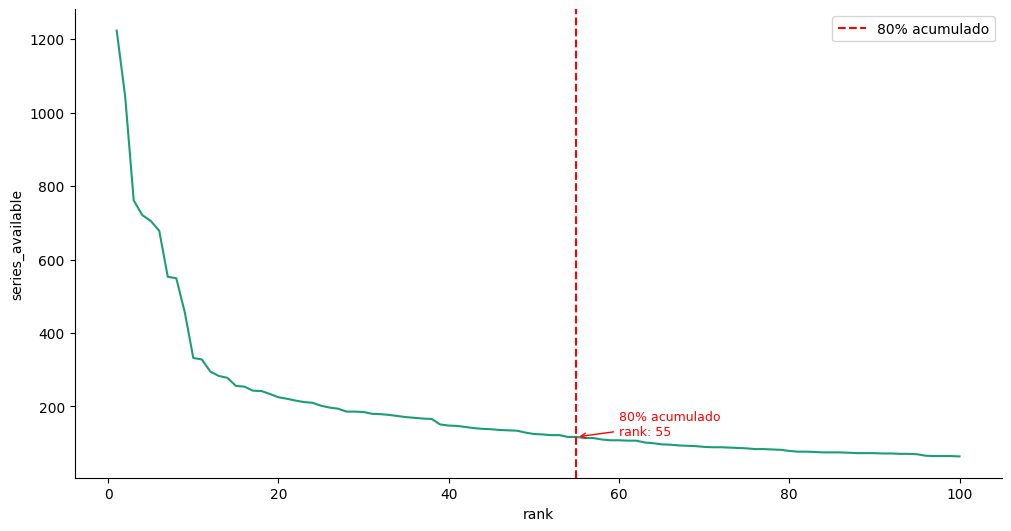

In [35]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rank']
  ys = series['series_available']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('rank', ascending=True)
_plot_series(df_sorted, '')

# Encontrar o ponto onde a porcentagem acumulada atinge 80%
pareto_point = df_sorted[df_sorted['pct_acumulada'] >= 80].iloc[0]

# Linha vertical no gráfico
plt.axvline(pareto_point['rank'], color='red', linestyle='--', linewidth=1.5, label='80% acumulado')

# Anotação no gráfico
plt.annotate(
    f"80% acumulado\nrank: {pareto_point['rank']}",
    xy=(pareto_point['rank'], pareto_point['series_available']),
    xytext=(pareto_point['rank'] + 5, pareto_point['series_available'] + 5),
    arrowprops=dict(arrowstyle='->', color='red'),
    fontsize=9,
    color='red'
)

plt.legend()

sns.despine(fig=fig, ax=ax)
plt.xlabel('rank')
_ = plt.ylabel('series_available')